In [11]:
!pip install torch torchvision matplotlib numpy pillow tensorflow scipy opencv-python scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]


In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2



In [3]:
train_path = 'data/train'
test_path = 'data/test'
val_path = 'data/val'

#understand the data distribution
# Each path has 2 directories: NORMAL and PNEUMONIA
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_pneumonia_path = os.path.join(val_path, 'PNEUMONIA')

# Count images in each category
train_normal_count = len(os.listdir(train_normal_path))
train_pneumonia_count = len(os.listdir(train_pneumonia_path))
test_normal_count = len(os.listdir(test_normal_path))
test_pneumonia_count = len(os.listdir(test_pneumonia_path))
val_normal_count = len(os.listdir(val_normal_path))
val_pneumonia_count = len(os.listdir(val_pneumonia_path))

# Count pneumonia by type (virus or bacteria)
train_pneumonia_files = os.listdir(train_pneumonia_path)
train_virus_count = sum(1 for f in train_pneumonia_files if 'virus' in f.lower())
train_bacteria_count = sum(1 for f in train_pneumonia_files if 'bacteria' in f.lower())

test_pneumonia_files = os.listdir(test_pneumonia_path)
test_virus_count = sum(1 for f in test_pneumonia_files if 'virus' in f.lower())
test_bacteria_count = sum(1 for f in test_pneumonia_files if 'bacteria' in f.lower())

val_pneumonia_files = os.listdir(val_pneumonia_path)
val_virus_count = sum(1 for f in val_pneumonia_files if 'virus' in f.lower())
val_bacteria_count = sum(1 for f in val_pneumonia_files if 'bacteria' in f.lower())

# Print label distribution
print(f"Training set   - NORMAL: {train_normal_count}, PNEUMONIA: {train_pneumonia_count} (Virus: {train_virus_count}, Bacteria: {train_bacteria_count})")
print(f"Testing set    - NORMAL: {test_normal_count}, PNEUMONIA: {test_pneumonia_count} (Virus: {test_virus_count}, Bacteria: {test_bacteria_count})")
print(f"Validation set - NORMAL: {val_normal_count}, PNEUMONIA: {val_pneumonia_count} (Virus: {val_virus_count}, Bacteria: {val_bacteria_count})")


Training set   - NORMAL: 1341, PNEUMONIA: 3875 (Virus: 1345, Bacteria: 2530)
Testing set    - NORMAL: 234, PNEUMONIA: 390 (Virus: 148, Bacteria: 242)
Validation set - NORMAL: 8, PNEUMONIA: 8 (Virus: 0, Bacteria: 8)


## Preprocessing


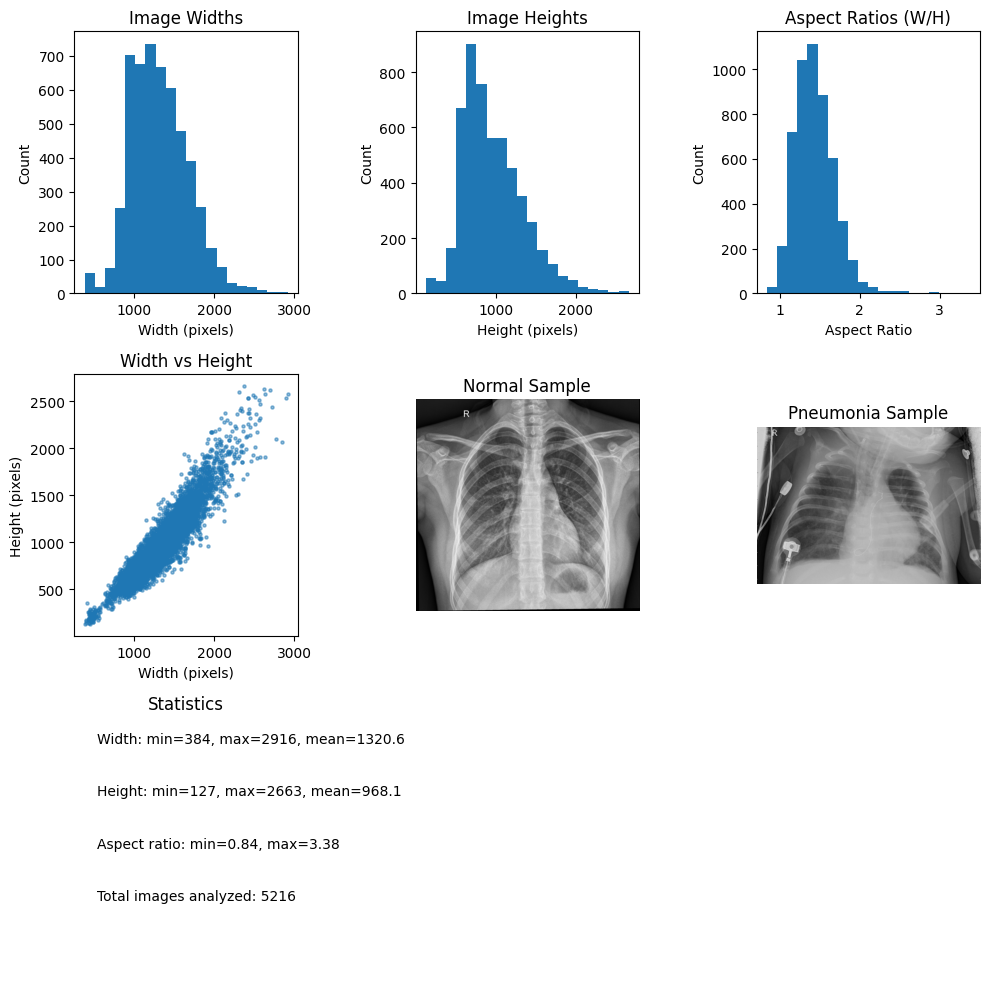

Image size analysis complete.
Average dimensions: 1320.6 x 968.1 pixels
Dimension range: Width 384-2916, Height 127-2663
Average aspect ratio: 1.440


In [4]:
# Analyze image size and proportion distribution
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to analyze images in a directory
def analyze_images(directory):
    sizes = []
    aspect_ratios = []
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        height, width = img.shape[:2]
                        sizes.append((width, height))
                        aspect_ratios.append(width / height)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return sizes, aspect_ratios

# Analyze images in training set
train_sizes, train_aspect_ratios = analyze_images(train_path)

# Create histograms and visualizations
plt.figure(figsize=(10, 10))

# Plot image widths
plt.subplot(3, 3, 1)
plt.hist([w for w, h in train_sizes], bins=20)
plt.title('Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

# Plot image heights
plt.subplot(3, 3, 2)
plt.hist([h for w, h in train_sizes], bins=20)
plt.title('Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

# Plot aspect ratios
plt.subplot(3, 3, 3)
plt.hist(train_aspect_ratios, bins=20)
plt.title('Aspect Ratios (W/H)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')

# Scatter plot of width vs height
plt.subplot(3, 3, 4)
plt.scatter([w for w, h in train_sizes], [h for w, h in train_sizes], alpha=0.5, s=5)
plt.title('Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# Plot some sample images
plt.subplot(3, 3, 5)
normal_sample = os.path.join(train_normal_path, os.listdir(train_normal_path)[0])
img = cv2.imread(normal_sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Normal Sample')
plt.axis('off')

plt.subplot(3, 3, 6)
pneumonia_sample = os.path.join(train_pneumonia_path, os.listdir(train_pneumonia_path)[0])
img = cv2.imread(pneumonia_sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Pneumonia Sample')
plt.axis('off')

# Calculate and print statistics
widths = [w for w, h in train_sizes]
heights = [h for w, h in train_sizes]

plt.subplot(3, 3, 7)
plt.text(0.1, 0.9, f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}", fontsize=10)
plt.text(0.1, 0.7, f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}", fontsize=10)
plt.text(0.1, 0.5, f"Aspect ratio: min={min(train_aspect_ratios):.2f}, max={max(train_aspect_ratios):.2f}", fontsize=10)
plt.text(0.1, 0.3, f"Total images analyzed: {len(train_sizes)}", fontsize=10)
plt.axis('off')
plt.title('Statistics')

plt.tight_layout()
plt.show()

print("Image size analysis complete.")
print(f"Average dimensions: {np.mean(widths):.1f} x {np.mean(heights):.1f} pixels")
print(f"Dimension range: Width {min(widths)}-{max(widths)}, Height {min(heights)}-{max(heights)}")
print(f"Average aspect ratio: {np.mean(train_aspect_ratios):.3f}")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


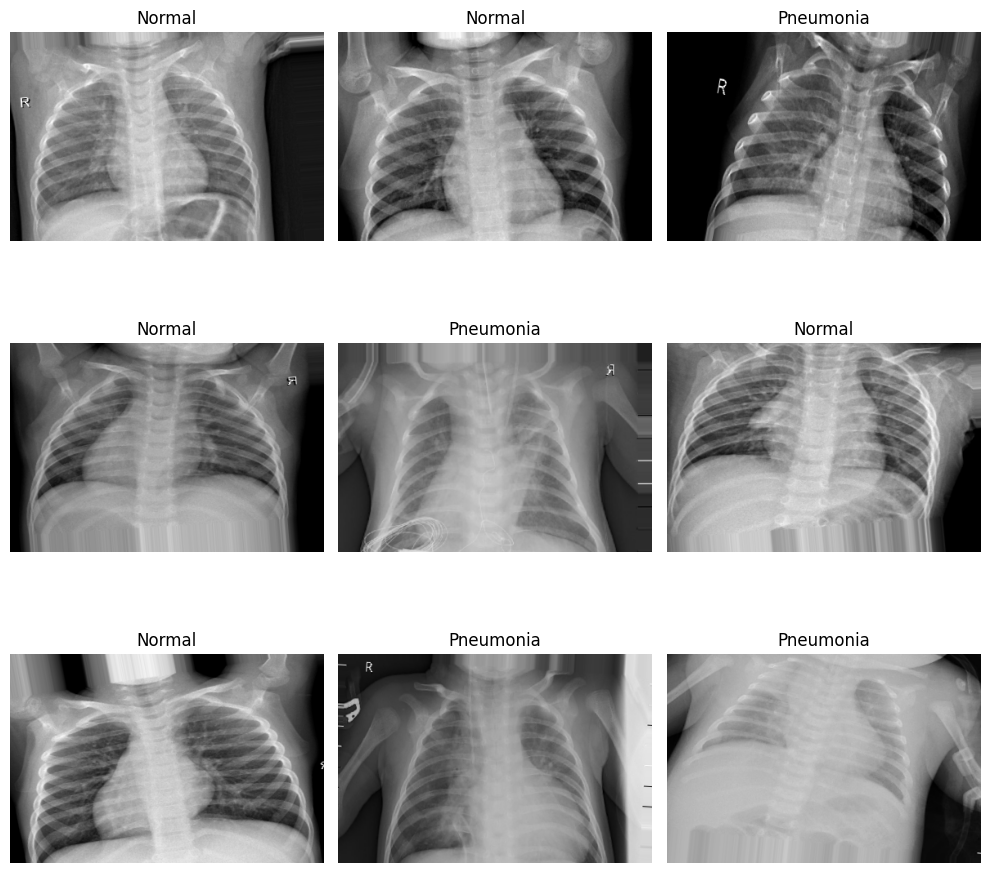

Training data shape: (32, 256, 384, 3)
Min pixel value: 0.0, Max pixel value: 1.0
Using scaled dimensions: 384x256 (original avg: 1320.6x968.1)
Aspect ratio: 1.500 (original avg: 1.440)


In [5]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Define image dimensions based on the analysis
# Using dimensions closer to the average while maintaining a reasonable size for the model
IMG_HEIGHT = 256  # Scaled down from average of 968.1
IMG_WIDTH = 384   # Scaled down from average of 1320.6, maintaining aspect ratio ~1.44
BATCH_SIZE = 32

# Create ImageDataGenerator for data augmentation and preprocessing
# For training data, we'll apply some augmentation to help with generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,  # X-rays can be flipped horizontally without changing diagnosis
    fill_mode='nearest'
)

# For validation and test data, we only rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Load and preprocess the validation data
validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load and preprocess the test data
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Display some sample images from the training set
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title('Normal' if label_batch[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
image_batch, label_batch = next(iter(train_generator))
show_batch(image_batch, label_batch)

print(f"Training data shape: {image_batch.shape}")
print(f"Min pixel value: {image_batch.min()}, Max pixel value: {image_batch.max()}")
print(f"Using scaled dimensions: {IMG_WIDTH}x{IMG_HEIGHT} (original avg: 1320.6x968.1)")
print(f"Aspect ratio: {IMG_WIDTH/IMG_HEIGHT:.3f} (original avg: 1.440)")


# Pad and Resize

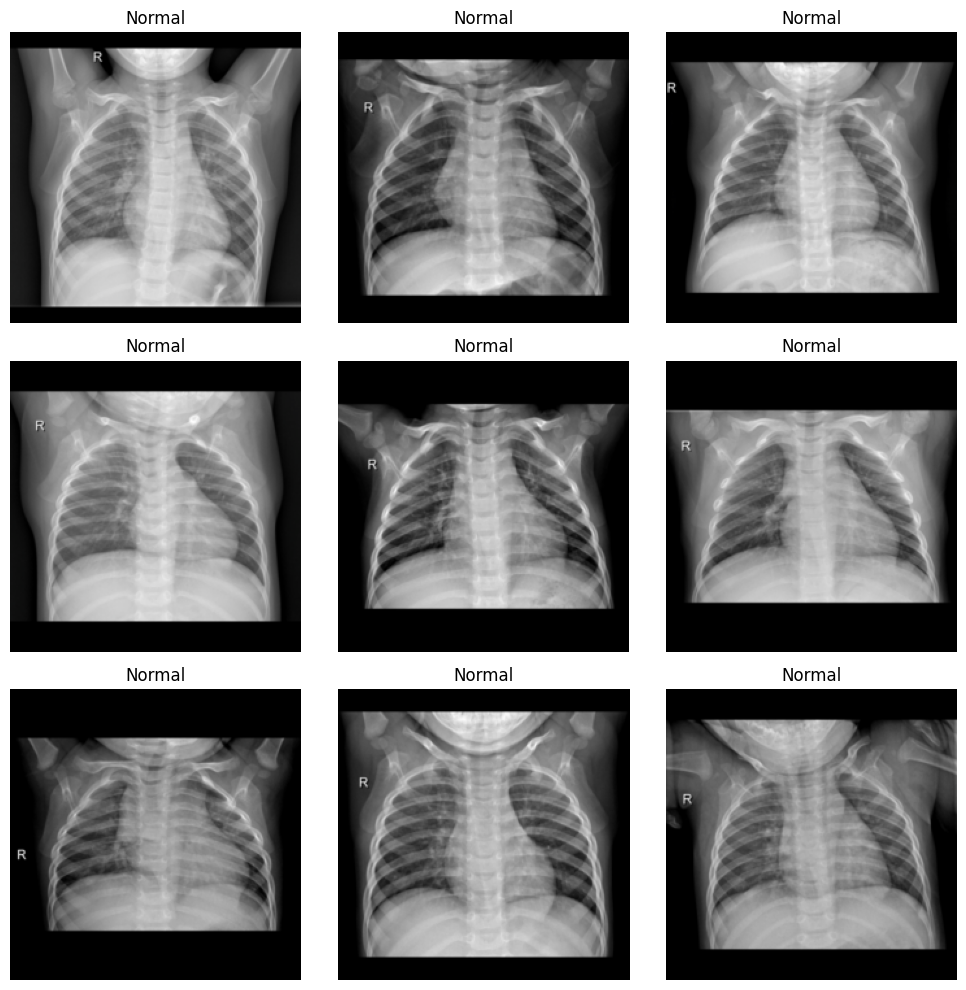

Padded and resized images using PyTorch transforms:
Shape: torch.Size([9, 3, 224, 224])
Min pixel value: -2.1179039478302, Max pixel value: 2.6225709915161133


In [7]:
# Define a preprocessing function to pad images to squares before resizing
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def pad_to_square(image):
    """Pad the image to make it square with zeros around the border."""
    w, h = image.size
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2
    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    return transforms.functional.pad(image, padding, fill=0)

# Define the transformation pipeline with 224x224 size
transform = transforms.Compose([
    transforms.Lambda(pad_to_square),               # Pad to square
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),    # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to load and transform a batch of images
def load_and_transform_batch(image_paths, labels):
    images = []
    for img_path in image_paths:
        img = Image.open(img_path)
        img = transform(img)
        images.append(img)
    
    # Stack images into a batch
    batch = torch.stack(images)
    return batch, torch.tensor(labels)

# Function to display transformed images
def show_transformed_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        # Convert from tensor to numpy for display
        img = image_batch[i].permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        
        # Clip values to valid range
        img = np.clip(img, 0, 1)
        
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title('Normal' if label_batch[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example of how to use with a few sample images from the training generator
# Get a batch of file paths and labels from the generator
image_paths = [train_generator.filepaths[i] for i in range(9)]
labels = [train_generator.classes[i] for i in range(9)]

# Load and transform the images
transformed_images, transformed_labels = load_and_transform_batch(image_paths, labels)

# Display the transformed images
show_transformed_batch(transformed_images, transformed_labels)

print("Padded and resized images using PyTorch transforms:")
print(f"Shape: {transformed_images.shape}")
print(f"Min pixel value: {transformed_images.min().item()}, Max pixel value: {transformed_images.max().item()}")


## CNN

In [12]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Define device for training (MPS for Mac M1/M2, GPU if available, otherwise CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare data for training
# First, we need to load all training images
all_train_paths = train_generator.filepaths
all_train_labels = train_generator.classes

# Load and transform all training images
print("Loading and transforming all training images...")
all_train_images, all_train_labels = load_and_transform_batch(all_train_paths, all_train_labels)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    all_train_images, all_train_labels, test_size=0.2, random_state=42, stratify=all_train_labels
)

print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}")

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the CNN model
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fourth convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fifth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x.squeeze()

# Initialize the model
model = PneumoniaCNN().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                predicted = torch.sigmoid(outputs) > 0.5
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Update learning rate
        scheduler.step(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 10
print(f"Starting training for {num_epochs} epochs...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate the model on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA']))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
torch.save(model.state_dict(), 'pneumonia_cnn_model.pth')
print("Model saved as 'pneumonia_cnn_model.pth'")



Using device: mps
Loading and transforming all training images...
Training set size: 4172, Validation set size: 1044
PneumoniaCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3)

TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'